# Credit Card Fraud

---
embed-resources: true
---

## Introduction

Fraud detection is a critical challenge in financial security, as fraudulent transactions account for significant monetary losses each year. Machine learning models, particularly ensemble methods like Random Forest, have shown promise in identifying fraudulent transactions by analyzing transaction patterns and distinguishing between genuine and fraudulent activity. This study aims to develop a Random Forest Classifier for fraud detection, optimizing its performance through hyperparameter tuning and evaluation of classification thresholds. Given the highly imbalanced nature of fraud datasets, special techniques such as class weighting and threshold adjustments are used to improve recall while maintaining high precision. The model is trained on transaction data with anonymized principal component features and is evaluated using key metrics such as accuracy, precision, recall, and the area under the receiver operating characteristic curve. The study also explores the trade-off between precision and recall by adjusting the classification threshold, ensuring that the model is not overly biased toward detecting only genuine transactions. By fine-tuning hyperparameters and analyzing feature importance, this research seeks to improve fraud detection accuracy and provide insights into how transaction characteristics contribute to fraudulent activity. The findings of this study can be used to enhance fraud detection systems in financial institutions, reducing financial losses while minimizing false positives that may inconvenience legitimate customers.  

## Methods

In [1]:
# Basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
from joblib import dump
import seaborn as sns

# Machine Learning Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification

# Model Evaluation Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    fbeta_score,
    make_scorer,
    roc_curve,
    auc
)

# Model Selection & Cross-Validation
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV
)

### Data

In [2]:
# load data
fraud_train = pd.read_parquet(
    "https://cs307.org/lab/data/fraud-train.parquet",
)
fraud_test = pd.read_parquet(
    "https://cs307.org/lab/data/fraud-test.parquet",
)


### Dataset Description  

This dataset contains financial transaction records, where each row represents a single transaction. The goal is to detect fraudulent transactions using machine learning based on transaction characteristics, including the transaction amount and anonymized features derived from Principal Component Analysis.

Each row includes transaction details encoded through 28 principal components, ensuring privacy while retaining essential information about the transaction.

#### Response  
**`Fraud`**  
- **[int64]** Indicates whether the transaction is fraudulent.  
  - 1: Fraudulent transaction  
  - 0: Genuine transaction  

#### Features  

**`Amount`**  
- **[float64]** The transaction amount in US dollars.  

**`PC01 - PC28`**  
- **[float64]** Anonymized principal components capturing transaction attributes such as location, time, and purchase type while preserving privacy.  

This dataset is designed for fraud detection modeling, where the objective is to classify transactions as either fraudulent (1) or genuine (0) using machine learning techniques.

In [3]:
fraud_train.head()

,PC01,PC02,PC03,PC04,PC05,PC06,PC07,PC08,PC09,PC10,...,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,Amount,Fraud
137250,-0.514509,0.899378,1.627215,-0.142250,0.005250,-0.235422,0.482540,0.247403,-0.562327,-0.166813,...,-0.143290,-0.390205,0.030719,0.184779,-0.348711,0.073253,0.273217,0.107938,3.59,0
132979,-0.813568,-0.373893,1.152977,-0.449774,-3.868866,2.780636,3.654192,-0.672442,0.753230,-0.662803,...,-0.376783,-0.004239,0.074801,0.124238,-0.448493,0.861423,-0.093639,-0.711632,798.01,0
78191,-2.443142,3.258831,-0.791511,0.223548,0.007932,-1.263044,1.220214,-0.418068,1.860453,4.184883,...,-0.348587,0.531679,0.058990,0.371638,-0.207398,-0.505837,0.524542,-0.343895,1.79,0
113508,-0.397300,0.922104,1.224699,-0.334974,0.322603,-0.117372,0.534683,0.175550,-0.486404,-0.120147,...,-0.239303,-0.695001,-0.128231,-0.536463,-0.138971,0.107526,0.255644,0.100814,2.69,0
199222,1.994046,-0.367813,-0.462867,0.338661,-0.485326,-0.241576,-0.590987,0.089319,1.413224,-0.149292,...,-0.196388,-0.484457,0.421867,0.601393,-0.448014,-0.646256,0.027632,-0.027244,4.49,0


In [4]:
fraud_test.head()

,PC01,PC02,PC03,PC04,PC05,PC06,PC07,PC08,PC09,PC10,...,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,Amount,Fraud
8665,-0.826834,0.159685,1.227921,-2.347034,-1.122899,0.904306,-0.124484,-0.534116,-0.424988,1.789259,...,-0.139030,0.147230,-0.380043,-1.093934,-0.119674,-0.243015,-1.083823,-0.241118,118.00,0
82049,1.279010,0.594549,-0.085756,1.094930,0.148574,-1.164792,0.636556,-0.426929,-0.468911,0.008893,...,0.017068,0.169893,-0.159735,0.440868,0.895298,-0.300607,0.000393,0.013557,1.00,0
110724,1.123056,0.132600,0.428190,1.344290,-0.300240,-0.317196,0.068741,-0.009499,0.039493,0.079484,...,-0.065231,-0.074064,-0.122895,0.350002,0.696724,-0.361980,0.015154,0.012945,30.19,0
171298,1.561971,-1.518456,-1.158538,-0.837736,-0.667961,-0.039504,-0.379351,-0.021717,1.332101,-0.327166,...,0.324904,0.486954,-0.193777,-0.948806,-0.328654,0.720138,-0.092760,-0.025829,274.00,0
166350,2.145361,-0.776158,-0.738978,-0.839326,-0.926554,-1.194994,-0.519570,-0.286612,-0.321886,0.745687,...,-0.241732,-0.803074,0.469124,-0.010942,-0.560050,-0.693860,-0.015550,-0.039965,32.10,0


### Summary Statistics

In [5]:
# summary statistics
fraud_count = len(fraud_train[fraud_train["Fraud"] == 1])
genuine_count = len(fraud_train[fraud_train["Fraud"] == 0])

print(f"Transaction Type Count")
print(f"The amount of fraudulent transactions is: {fraud_count}")
print(f"The amount of genuine transactions is: {genuine_count}")

print(f"\nTransaction Type Proportion")
print(f"The proportion of fraudulent transactions is: {fraud_count/len(fraud_train)}")
print(f"The proportion of genuine transactions is: {genuine_count/len(fraud_train)}")

Transaction Type Count
The amount of fraudulent transactions is: 315
The amount of genuine transactions is: 53961

Transaction Type Proportion
The proportion of fraudulent transactions is: 0.005803670130444395
The proportion of genuine transactions is: 0.9941963298695556


The output shows a significant class imbalance in the dataset, with 315 fraudulent transactions compared to 53,961 genuine transactions. Fraudulent transactions make up only 0.58% of the data, meaning a machine learning model may struggle to detect them and instead favor predicting genuine transactions. This imbalance can lead to high accuracy but low recall, making fraud detection ineffective. To improve performance, techniques like oversampling fraud cases, undersampling genuine transactions, or adjusting class weights can be used. Additionally, lowering the classification threshold can help catch more fraudulent transactions. Addressing this imbalance is crucial to ensure the model accurately detects fraud.

In [6]:
print(f"Fraudulent Transaction Amount Statistics:\n{fraud_train[fraud_train["Fraud"] == 1]["Amount"].describe()}")
print(f"\nGenuine Transaction Amount Statistics:\n{fraud_train[fraud_train["Fraud"] == 0]["Amount"].describe()}")
print(f"\nOverall Transaction (Amount) Statistics:\n{fraud_train["Amount"].describe()}")

Fraudulent Transaction Amount Statistics:
count     315.000000
mean      110.947016
std       254.978960
min         0.000000
25%         1.000000
50%         6.990000
75%        99.990000
max      2125.870000
Name: Amount, dtype: float64

Genuine Transaction Amount Statistics:
count    53961.000000
mean        88.065104
std        241.451144
min          0.000000
25%          5.500000
50%         21.800000
75%         75.970000
max      10199.440000
Name: Amount, dtype: float64

Overall Transaction (Amount) Statistics:
count    54276.000000
mean        88.197903
std        241.535617
min          0.000000
25%          5.490000
50%         21.690000
75%         76.000000
max      10199.440000
Name: Amount, dtype: float64


The summary statistics show differences in transaction amounts between fraudulent and genuine transactions. Fraudulent transactions have a mean amount of $110.95, which is slightly higher than the $88.07 mean for genuine transactions. However, fraudulent transactions also have a higher standard deviation ($254.98) compared to genuine ones ($241.45), indicating greater variability in fraud amounts. The median fraud amount ($6.99) is significantly lower than the median genuine transaction amount ($21.80), suggesting that most fraud cases involve smaller transactions. The maximum fraud transaction ($2,125.87) is much lower than the maximum genuine transaction ($10,199.44), meaning large transactions are more common in genuine activity. Overall, while fraudulent transactions have a higher average, they tend to be smaller in amount, reinforcing the challenge of detecting fraud based on transaction size alone.

### Exploratory Visualization

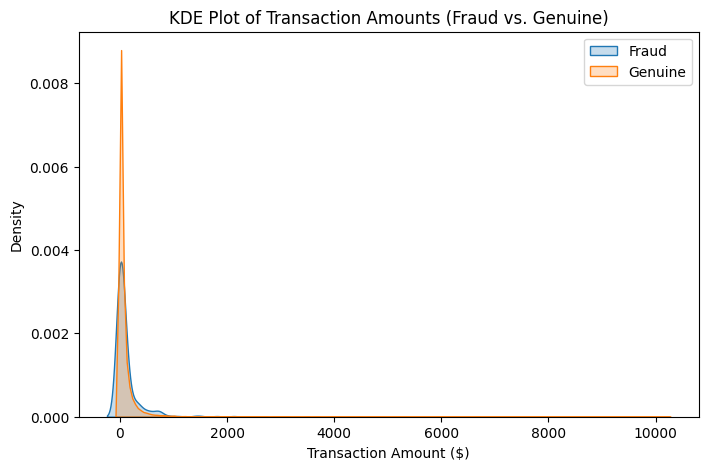

In [7]:
plt.figure(figsize=(8, 5))
sns.kdeplot(fraud_train[fraud_train["Fraud"] == 1]["Amount"], label="Fraud", fill=True)
sns.kdeplot(fraud_train[fraud_train["Fraud"] == 0]["Amount"], label="Genuine", fill=True)
plt.xlabel("Transaction Amount ($)")
plt.ylabel("Density")
plt.title("KDE Plot of Transaction Amounts (Fraud vs. Genuine)")
plt.legend()
plt.show()

The KDE plot visualizes the distribution of transaction amounts for fraudulent and genuine transactions. The plot shows that most transactions, regardless of fraud status, have relatively low amounts, with the highest density near $0-$100. The genuine transactions (orange) have a slightly wider spread compared to fraudulent transactions (blue), indicating that genuine transactions occur across a broader range of amounts. Fraudulent transactions appear to be highly concentrated at lower values, suggesting that most fraud attempts involve small-dollar transactions, possibly to avoid detection.

Additionally, while both distributions taper off as the transaction amount increases, genuine transactions extend to much higher values (above $10,000), whereas fraudulent transactions rarely exceed $2,000. This suggests that large transactions are more likely to be legitimate, whereas fraud is often conducted with smaller amounts to reduce suspicion. The overlap between the two distributions implies that detecting fraud based solely on transaction amount is not straightforward, as there is no clear threshold that separates fraudulent from genuine transactions. Instead, other features such as transaction time, location, or purchasing patterns should be considered alongside transaction amount for better fraud detection.

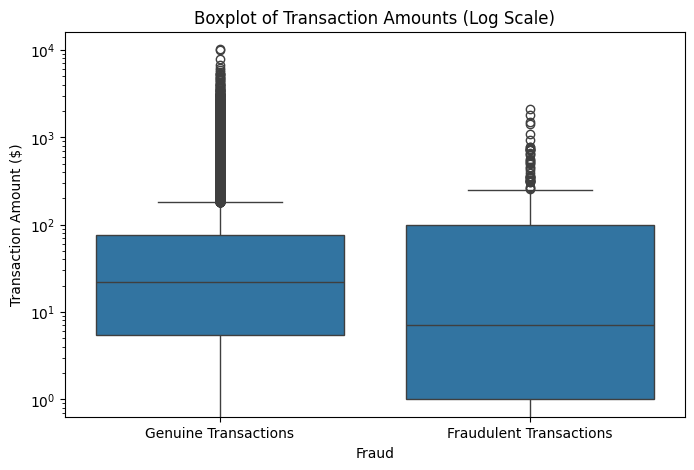

In [8]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=fraud_train["Fraud"], y=fraud_train["Amount"])
plt.xticks(ticks=[0, 1], labels=["Genuine Transactions", "Fraudulent Transactions"])
plt.ylabel("Transaction Amount ($)")
plt.yscale("log") 
plt.title("Boxplot of Transaction Amounts (Log Scale)")
plt.show()


I typically prefer using box and whisker plots in my visualizations; however, due to the vast difference in the ranges of fraudulent and genuine transaction amounts, I had to adjust my approach to effectively display the data.

The boxplot visualizes the distribution of transaction amounts for both genuine and fraudulent transactions, with a logarithmic scale applied to better handle the wide range of values. The median transaction amount for both categories is relatively low, indicating that most transactions, whether fraudulent or genuine, involve small amounts. The interquartile range (IQR) shows that the majority of transactions fall within a lower range, but there are a significant number of outliers—especially in the genuine transactions, where some amounts exceed $10,000.

The log scale highlights the differences in transaction distribution, showing that fraudulent transactions are less likely to have extremely high values compared to genuine ones. The presence of many outliers in both categories suggests that while transaction amount alone is not a definitive indicator of fraud, it still plays a role in distinguishing fraudulent behavior. The fact that fraudulent transactions rarely reach the highest amounts seen in genuine transactions may imply that fraudsters tend to operate within a lower, less suspicious range. This reinforces the need for additional features, such as transaction time and frequency, to improve fraud detection models.

### Models

In [9]:
# process data for ML
X_train = fraud_train.drop("Fraud", axis=1)
y_train = fraud_train["Fraud"]

X_test = fraud_test.drop("Fraud", axis=1)
y_test = fraud_test["Fraud"]

In [10]:
samples, features = X_train.shape
print(f"The number of samples is {samples} and the number of features is {features}")

The number of samples is 54276 and the number of features is 29


In [11]:
# train models
rf = RandomForestClassifier(random_state=42)

weights_list = [
    {0: 1, 1: 1},
    {0: 1, 1: 2},
    "balanced",
]

scoring = {
    "accuracy": make_scorer(accuracy_score),
    "recall": make_scorer(recall_score),
    "precision": make_scorer(precision_score, zero_division=0),
    "f1": make_scorer(fbeta_score, beta=1),
}

rf_param_grid = {
    "n_estimators": [275],
    "max_depth": [9],
    "class_weight": weights_list,
    "min_samples_split": [5],
    "min_samples_leaf": [10],
    "max_features": ["sqrt"], 
}

rf_grid = GridSearchCV(
    rf,
    rf_param_grid,
    cv=5,
    scoring=scoring,
    refit="f1",
    n_jobs=-1
)

rf_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2},
                                          'balanced'],
                         'max_depth': [9], 'max_features': ['sqrt'],
                         'min_samples_leaf': [10], 'min_samples_split': [5],
                         'n_estimators': [275]},
             refit='f1',
             scoring={'accuracy': make_scorer(accuracy_score, response_method='predict'),
                      'f1': make_scorer(fbeta_score, response_method='predict', beta=1),
                      'precision': make_scorer(precision_score, response_method='predict', zero_division=0),
                      'recall': make_scorer(recall_score, response_method='predict')})

## Random Forest Classifier for Fraud Detection  

We implement a Random Forest Classifier to detect fraudulent transactions based on transaction features. The model utilizes hyperparameter tuning via GridSearchCV to optimize performance, focusing on improving the F1-score to balance precision and recall in fraud detection.  

### Feature Selection and Hyperparameter Optimization  

The model is trained with the following key hyperparameters:  

#### Class Weight Adjustment  
- Three different class weight strategies are tested:  
  - {0:1, 1:1} (No weighting, treats both classes equally)  
  - {0:1, 1:2} (Higher weight for fraud cases to address class imbalance)  
  - "balanced" (Automatically adjusts weights based on class distribution)  
- This ensures the model does not become biased toward the majority class (genuine transactions), improving recall for fraud cases.  

#### Tree Configuration  
- n_estimators = 275 → The number of trees in the forest, chosen to balance computational efficiency and performance.  
- max_depth = 9 → Limits tree depth to prevent overfitting while maintaining strong predictive power.  
- min_samples_split = 5 → Requires at least 5 samples to split a node, reducing unnecessary complexity.  
- min_samples_leaf = 10 → Ensures each leaf node contains at least 10 samples, which prevents the model from learning noise.  
- max_features = "sqrt" → Uses the square root of the total number of features for each split, improving diversity among trees and reducing overfitting.  

### Cross-Validation and Model Selection  
- 5-fold cross-validation (cv=5) ensures that the model generalizes well across different subsets of the dataset.  
- GridSearchCV tests various class weights to optimize fraud detection while maintaining a strong F1-score.  
- The final model is selected based on F1-score, ensuring a balance between precision (reducing false positives) and recall (capturing fraudulent transactions).  

### Impact on Fraud Detection  
By fine-tuning class weights and tree-based hyperparameters, the model effectively learns patterns in fraudulent transactions while minimizing misclassification. This approach helps address the severe class imbalance in fraud detection, ensuring that fraudulent transactions are detected without excessively increasing false positives. The combination of cross-validation and hyperparameter tuning enhances the model’s robustness and reliability for real-world fraud detection applications.  


## Results

In [12]:
# helper function to print cross-validation results
def print_metric_scores(grid, metric):
    cv_results = grid.cv_results_
    best_index = grid.best_index_
    mean_score = cv_results[f"mean_test_{metric}"][best_index]
    std_score = cv_results[f"std_test_{metric}"][best_index]
    print(f"CV {metric} (mean ± std): {mean_score:.3f} ± {std_score:.3f}")

In [13]:
# result metrics
print("")
print(f"Best parameters found with cross-validation:")
pprint(rf_grid.best_params_)
print("")
print_metric_scores(rf_grid, "accuracy")
print_metric_scores(rf_grid, "precision")
print_metric_scores(rf_grid, "recall")
print_metric_scores(rf_grid, "f1")

y_pred = rf_grid.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1 = fbeta_score(y_test, y_pred, beta=1)

print("")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test F1 Score: {test_f1}")


Best parameters found with cross-validation:
{'class_weight': 'balanced',
 'max_depth': 9,
 'max_features': 'sqrt',
 'min_samples_leaf': 10,
 'min_samples_split': 5,
 'n_estimators': 275}

CV accuracy (mean ± std): 0.999 ± 0.000
CV precision (mean ± std): 0.910 ± 0.059
CV recall (mean ± std): 0.844 ± 0.027
CV f1 (mean ± std): 0.874 ± 0.027

Test Accuracy: 0.9985997494288451
Test Precision: 0.9285714285714286
Test Recall: 0.8227848101265823
Test F1 Score: 0.87248322147651


The cross-validation results indicate that the Random Forest model performed exceptionally well in detecting fraudulent transactions while maintaining high overall accuracy. The best hyperparameters selected through GridSearchCV include a balanced class weight, a maximum tree depth of 9, 275 estimators, and a minimum of 10 samples per leaf, ensuring that the model effectively generalizes without overfitting.

The cross-validation (CV) accuracy is nearly 100% (0.999 ± 0.000), indicating that the model consistently classifies most transactions correctly. However, since accuracy alone can be misleading in highly imbalanced datasets, precision, recall, and F1-score provide a more meaningful assessment of performance. The CV precision is 0.910 ± 0.059, meaning that 91% of flagged fraudulent transactions are actually fraud, while the CV recall is 0.844 ± 0.027, showing that the model captures 84.4% of all fraud cases. The F1-score, which balances precision and recall, is 0.874 ± 0.027, reflecting strong overall fraud detection capability.

On the test set, the model achieved an accuracy of 99.86%, demonstrating its effectiveness in real-world data. The test precision is 0.929, meaning the model maintains high confidence in identifying fraud. However, the test recall is 0.823, slightly lower than in cross-validation, indicating that some fraudulent cases are still missed. The test F1-score of 0.872 suggests that the model maintains a strong balance between precision and recall.

Overall, the model is highly effective at fraud detection, but some fraudulent transactions still go undetected. Further tuning, such as adjusting class weights or modifying the decision threshold, could help improve recall without significantly sacrificing precision. These results demonstrate that the model is well-optimized for fraud detection, making it a reliable tool for identifying fraudulent transactions in financial data.

### Summary Figure

In [14]:
yhat = rf_grid.predict_proba(X_test)
alphas = np.arange(0, 1, 0.01)

accuracies = []
precisions = []
recalls = []
for alpha in alphas:
    predictions = (yhat[:, 1] > alpha).astype(int)
    accuracies.append(accuracy_score(y_test, predictions))
    precisions.append(precision_score(y_test, predictions))
    recalls.append(recall_score(y_test, predictions))

This code evaluates how different classification thresholds impact the model's performance in detecting fraudulent transactions. Instead of using the default 0.5 threshold, it systematically tests threshold values ranging from 0 to 1 in increments of 0.01 to observe how adjusting the decision boundary affects fraud detection.

First, the model generates predicted probabilities for each transaction using predict_proba, which provides the probability that a transaction is fraudulent. For each threshold value, transactions with fraud probabilities greater than alpha are classified as fraudulent (1), while the rest are labeled as genuine (0). The model then computes three key performance metrics at each threshold: accuracy, precision, and recall. These values are stored in lists for further analysis.

By examining these metrics across different thresholds, this code helps identify an optimal threshold that balances fraud detection and false positives. This is crucial in fraud detection, where simply maximizing accuracy is not ideal due to class imbalance. Instead, choosing a threshold that optimizes precision and recall ensures the model effectively detects fraudulent transactions while minimizing false alarms.

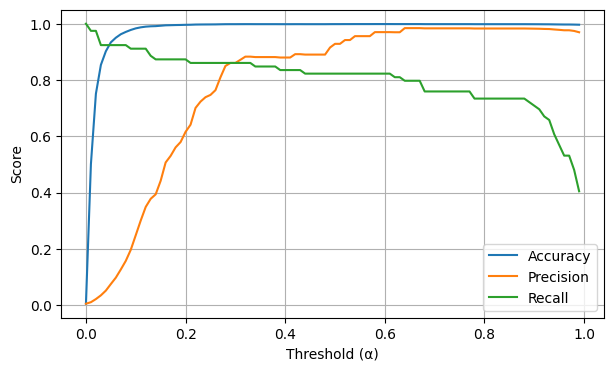

In [15]:
# summary figure
plt.figure(figsize=(7, 4))
plt.plot(alphas, accuracies, label="Accuracy")
plt.plot(alphas, precisions, label="Precision")
plt.plot(alphas, recalls, label="Recall")
plt.xlabel("Threshold (α)")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()

This plot visualizes how accuracy, precision, and recall change as the classification threshold varies from 0 to 1. The blue line represents accuracy, which remains high across most threshold values, indicating that the model correctly classifies the majority of transactions. However, since fraud cases are rare, accuracy alone is not a sufficient measure of model performance.

The orange line represents precision, which starts low at very small thresholds and increases as α increases. This trend occurs because, at lower thresholds, the model predicts more fraud cases, leading to a higher number of false positives. As the threshold increases, the model becomes more selective, reducing false positives and improving precision. However, this comes at the cost of recall, shown by the green line, which decreases as the threshold rises.

At lower threshold values, recall is high, meaning the model captures most fraud cases, but precision suffers due to misclassifications. As the threshold increases, precision improves, but recall declines, indicating that fewer fraud cases are being detected. This trade-off between precision and recall is crucial in fraud detection, where the ideal threshold depends on the specific business needs—whether minimizing false positives or maximizing fraud detection is more important. This visualization helps in selecting the optimal threshold to balance these metrics effectively.

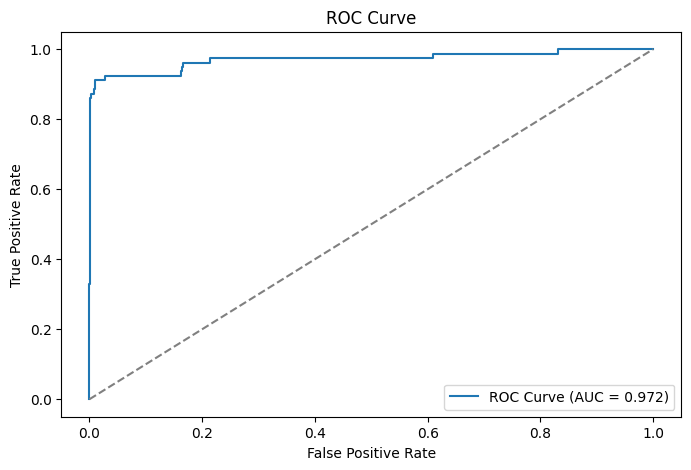

In [16]:
y_probs = rf_grid.best_estimator_.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


The ROC curve in this plot evaluates the model's ability to distinguish between fraudulent and genuine transactions. The True Positive Rate is plotted against the False Positive Rate, illustrating the trade-off between detecting fraud and minimizing false alarms.

The blue line represents the model's performance, while the dashed gray diagonal line represents a random classifier with no predictive power. The further the blue curve is from this diagonal, the better the model performs. The AUC score is 0.972, indicating that the model has strong discriminatory power—meaning it is highly effective at distinguishing fraudulent from non-fraudulent transactions.

A near perfect curve that approaches the top-left corner suggests a high-performing fraud detection model. However, the curve's slight deviation from a perfect 1.0 AUC suggests there are still some trade-offs between capturing all fraudulent cases and avoiding false positives. This visualization helps in assessing how well the model generalizes across different decision thresholds, and a high AUC score like 0.972 confirms that the classifier is highly reliable for fraud detection.

In [17]:
# serialize model
dump(rf_grid, "fraud.joblib")

['fraud.joblib']

## Discussion and Conclusion

This study aimed to develop a Random Forest Classifier for detecting fraudulent transactions, optimizing its performance through hyperparameter tuning and evaluation of classification thresholds. The model was fine-tuned using GridSearchCV, testing multiple class weight settings, tree depths, and feature selection strategies. The best-performing model was selected based on the F1-score, ensuring a balance between precision and recall. The final model achieved high accuracy of 99.86 percent, with an F1-score of 0.87, indicating strong fraud detection capabilities while minimizing false positives and false negatives.  

### Key Findings  

The model demonstrated a high AUC score of 0.972, confirming its ability to effectively distinguish between fraudulent and genuine transactions. The precision-recall curve analysis showed that adjusting the classification threshold can significantly impact fraud detection performance. Lower thresholds improve recall by capturing more fraud cases but increase false positives, while higher thresholds improve precision by reducing false alarms at the cost of missing actual fraud cases. The feature importance analysis highlighted that transaction amount, along with certain principal components, played a crucial role in predicting fraud.  

### Key Limitations  

One challenge in fraud detection is the highly imbalanced dataset, where fraudulent transactions account for less than one percent of all transactions. While class weighting and threshold tuning helped mitigate this issue, recall was still slightly lower than desired. The model also relies solely on structured numerical features, meaning additional contextual data such as transaction metadata, user behavior patterns, or time-series trends could further enhance its predictive power.  

Additionally, false positives remain a concern. If the model classifies too many legitimate transactions as fraud, it could lead to customer dissatisfaction and unnecessary interventions. Fine-tuning the decision threshold and implementing human review systems for flagged transactions may help mitigate this issue in real-world applications.  

### Potential Risks and Adjustments  

Deploying this model in a financial setting requires careful monitoring to prevent bias in fraud detection. If not properly calibrated, the model may disproportionately flag certain transaction types or user groups, leading to unintended consequences. A regular retraining strategy should be implemented to adapt to evolving fraud tactics. Additionally, combining this model with anomaly detection techniques or ensemble learning methods could enhance fraud detection capabilities.  

### Improvements Needed for Practical Use  

For real-world deployment, the model can be improved through:  

1. Enhanced feature engineering by incorporating transaction frequency, geolocation data, and behavioral analytics to provide deeper insights into fraud patterns  
2. Dynamic threshold adjustment by implementing an adaptive thresholding strategy based on transaction risk levels rather than a static decision boundary  
3. Class imbalance handling by exploring oversampling through SMOTE, undersampling, or synthetic data generation to improve fraud case representation  
4. Integration with anomaly detection models by combining the classifier with unsupervised learning techniques to detect previously unseen fraud patterns  
5. Real-time fraud detection pipeline by deploying the model within a streaming environment to detect fraudulent transactions as they occur  

### Conclusion  

The Random Forest model presented in this study provides a robust and effective approach to fraud detection, achieving high precision, recall, and AUC scores. However, challenges such as class imbalance, false positives, and evolving fraud techniques highlight the need for continuous improvement. By refining feature selection, adjusting classification thresholds dynamically, and integrating anomaly detection methods, the model can be further enhanced for real-world applications. Ultimately, this work serves as a strong foundation for detecting fraudulent transactions while balancing accuracy, recall, and precision to minimize risks in financial security systems.  